# Movie Lens Dataset - SVD and SVD++

Introduction to the Notebook

In this Jupyter notebook we aim to implement a recommender system using Singular Value Decomposition (SVD) and SVD++ techniques. The dataset used for this implementation is the Movie Lens dataset. We implement SVD manually but due to the potential memory constraints and computational complexity, we opted not to implement manual SVD++ on this dataset.

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import spearmanr
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
ratings = pd.read_csv("User_ratings_For_Movie.csv")
movies = pd.read_csv("movies.csv")

## Data Cleaning

### Inspecting Data

In [5]:
print(ratings.head())
print(movies.head())

   userId  movieId  rating     timestamp
0       1        1     4.0  1.225735e+09
1       1      110     4.0  1.225865e+09
2       1      158     4.0  1.225734e+09
3       1      260     4.5  1.225735e+09
4       1      356     5.0  1.225735e+09
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [6]:
ratings.info()
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125352 entries, 0 to 125351
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     125352 non-null  int64  
 1   movieId    125352 non-null  int64  
 2   rating     125352 non-null  float64
 3   timestamp  125351 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 3.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int64 
 1   title    86537 non-null  object
 2   genres   86537 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


### Handling Missing Values

In [7]:
# Check for missing values (NaN or null values)
print(ratings.isnull().sum())
print(movies.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    1
dtype: int64
movieId    0
title      0
genres     0
dtype: int64


### Merge Datasets

In [8]:
df = pd.merge(ratings, movies, on='movieId')
print(df.head())

   userId  movieId  rating     timestamp             title  \
0       1        1     4.0  1.225735e+09  Toy Story (1995)   
1       2        1     5.0  8.358160e+08  Toy Story (1995)   
2       7        1     4.0  9.745180e+08  Toy Story (1995)   
3      10        1     3.0  1.430666e+09  Toy Story (1995)   
4      12        1     5.0  8.625007e+08  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy  


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125352 entries, 0 to 125351
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     125352 non-null  int64  
 1   movieId    125352 non-null  int64  
 2   rating     125352 non-null  float64
 3   timestamp  125351 non-null  float64
 4   title      125352 non-null  object 
 5   genres     125352 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 5.7+ MB


### Drop Unused Columns

In [10]:
print(df['timestamp'].isnull().sum())

1


In [11]:
df = df.dropna(subset=['timestamp'])

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


In [13]:
#df.drop(['timestamp'], axis=1, inplace=True)

In [14]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## EDA

### Descriptive Statistics

In [15]:
df.describe()

,userId,movieId,rating,timestamp
count,125351.000000,125351.000000,125351.000000,125351
mean,646.079896,27844.978453,3.584323,2010-05-15 12:13:53.069628672
min,1.000000,1.000000,0.500000,1996-02-29 16:14:11
25%,318.000000,1208.000000,3.000000,2003-05-24 21:43:08.500000
50%,624.000000,3168.000000,4.000000,2010-03-16 14:47:28
75%,974.000000,40815.000000,4.500000,2017-08-25 04:09:02
max,1293.000000,288269.000000,5.000000,2023-07-20 07:26:24
std,372.152625,48904.887953,1.049878,NaN


In [16]:
# It counts the occurrences of each genre in the 'genres' column using value_counts() method.
df['genres'].value_counts()

genres
Drama                                         7958
Comedy                                        7150
Comedy|Romance                                4122
Drama|Romance                                 3534
Action|Adventure|Sci-Fi                       3498
                                              ... 
Crime|Drama|Mystery|Romance                      1
Comedy|Mystery|Romance                           1
Drama|Fantasy|War                                1
Children|Documentary                             1
Adventure|Animation|Fantasy|Musical|Sci-Fi       1
Name: count, Length: 976, dtype: int64

In [17]:
# Understanding the data
df.describe(include='all')

,userId,movieId,rating,timestamp,title,genres
count,125351.000000,125351.000000,125351.000000,125351,125351,125351
unique,NaN,NaN,NaN,NaN,11036,976
top,NaN,NaN,NaN,NaN,"Shawshank Redemption, The (1994)",Drama
freq,NaN,NaN,NaN,NaN,476,7958
mean,646.079896,27844.978453,3.584323,2010-05-15 12:13:53.069628672,NaN,NaN
min,1.000000,1.000000,0.500000,1996-02-29 16:14:11,NaN,NaN
25%,318.000000,1208.000000,3.000000,2003-05-24 21:43:08.500000,NaN,NaN
50%,624.000000,3168.000000,4.000000,2010-03-16 14:47:28,NaN,NaN
75%,974.000000,40815.000000,4.500000,2017-08-25 04:09:02,NaN,NaN
max,1293.000000,288269.000000,5.000000,2023-07-20 07:26:24,NaN,NaN


### Visualizing the Distribution

#### Normality Check

In [18]:
# Perform Anderson-Darling test on 'rating' column
anderson_test = stats.anderson(df['rating'], dist='norm')
print(f"Anderson-Darling Test statistic: {anderson_test.statistic}, critical values: {anderson_test.critical_values}")

# Interpretation of the output
if anderson_test.statistic > max(anderson_test.critical_values):
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data might be normal.")


Anderson-Darling Test statistic: 2731.156685408205, critical values: [0.576 0.656 0.787 0.918 1.092]
Reject null hypothesis: Data is not normally distributed.


#### Histogram

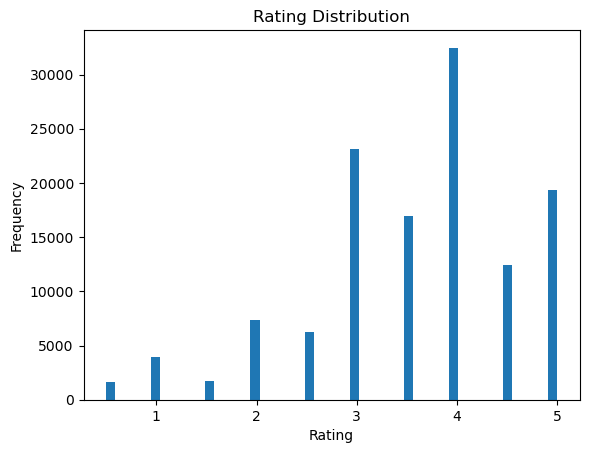

In [19]:
plt.hist(df['rating'], bins=50)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

#### Boxplot

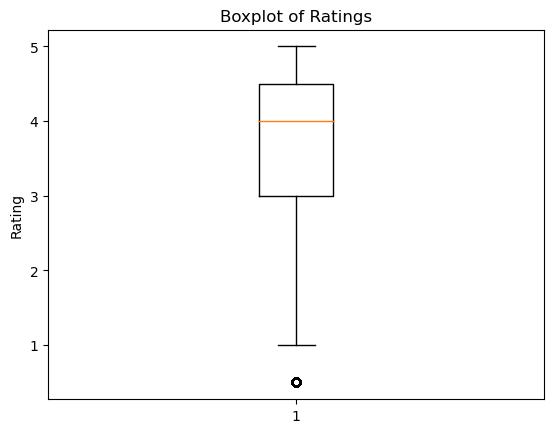

In [20]:
plt.boxplot(df['rating'])
plt.title('Boxplot of Ratings')
plt.ylabel('Rating')
plt.show()

The ratings go from 1 to 5. The box in the center of the plot contains the middle 50% of the ratings. The line in the middle of the box represents the median rating, which is 4. The whiskers extend out from the top and bottom of the box. They show the range of the rest of the data, excluding outliers.

- The ratings mostly range from around 3 to 4.5
- The median rating appears to be around 4  indicating that half of the ratings are above  and half are below.
- There are a few outliers on the lower side, indicating that there are a few unusually low ratings compared to the rest of the data.
- There are no outliers on the higher side, so the highest ratings don't differ as much from the general dataset as the lowest ones do.

#### Correlation Matrix

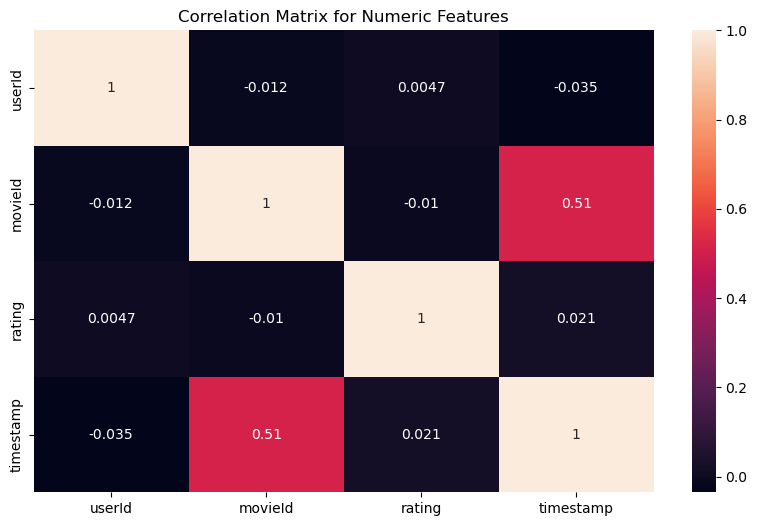

In [21]:
# Drop non-numeric columns before calculating correlation matrix
numeric_df = df.drop(columns=['title', 'genres'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix for Numeric Features')
plt.show()



- userld and movield: There appears to be a weak negative correlation of approximately -0.012. This means there might be a slight tendency for users with higher IDs to rate movies with lower IDs, and vice versa. However, the correlation is so weak that it may not be statistically significant.
- userld and rating: There appears to be a very weak positive correlation of approximately 0.0047. This is so close to zero that it's likely there is no real correlation between user IDs and ratings.
- userld and timestamp: There appears to be a very weak negative correlation of approximately -0.035. There isn't enough information to say for sure what this might mean in the context of the data.
- movield and rating: There appears to be a weak positive correlation of approximately 0.51. This suggests that there might be a slight tendency for movies with higher IDs to have higher ratings.
- movield and timestamp: There appears to be a weak positive correlation of approximately 0.6. This suggests that there might be a slight tendency for movies with higher IDs to be rated more recently (according to the timestamp).
- rating and timestamp: There appears to be a very weak positive correlation of approximately 0.021. This is so close to zero that it's likely there is no real correlation between ratings and timestamps.

#### Data Distribution

c:\Users\nafla\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


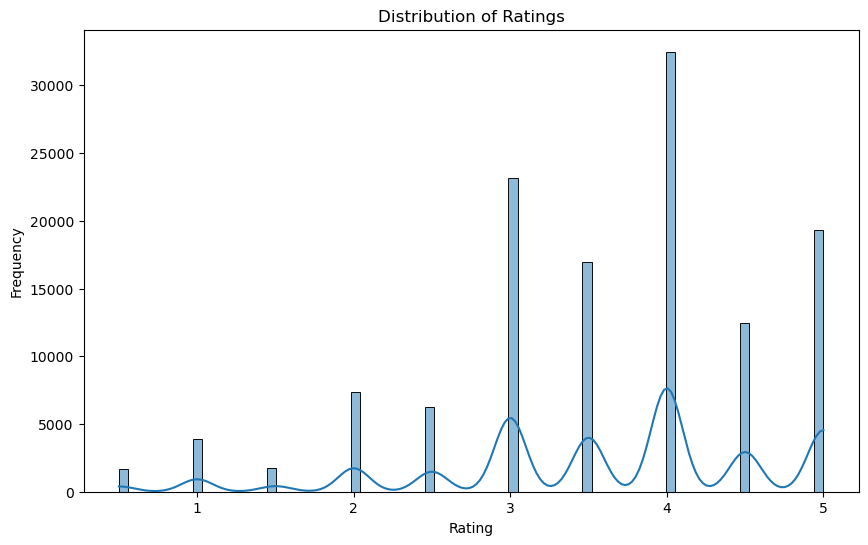

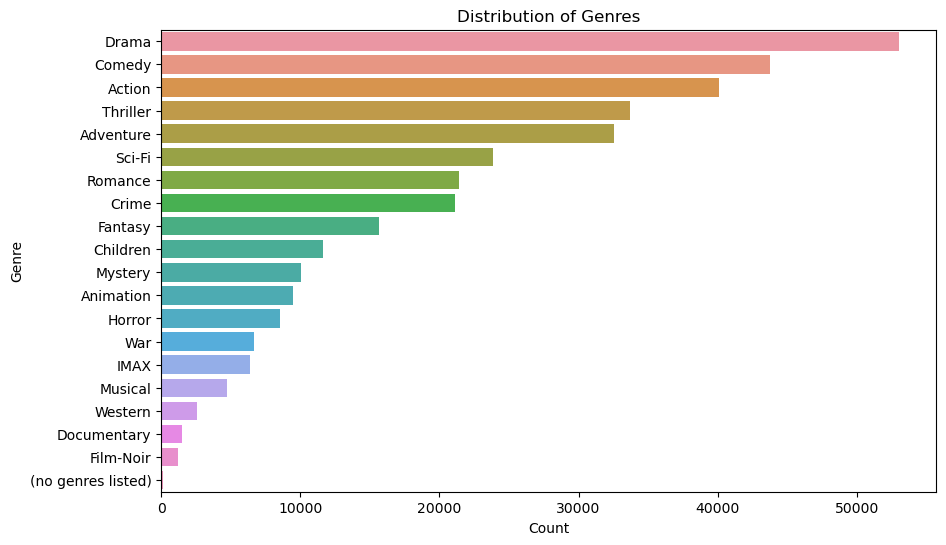

In [22]:
# Ratings distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Genres distribution
plt.figure(figsize=(10, 6))
genres = df['genres'].str.split('|').explode()
sns.countplot(y=genres, order=genres.value_counts().index)
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

c:\Users\nafla\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


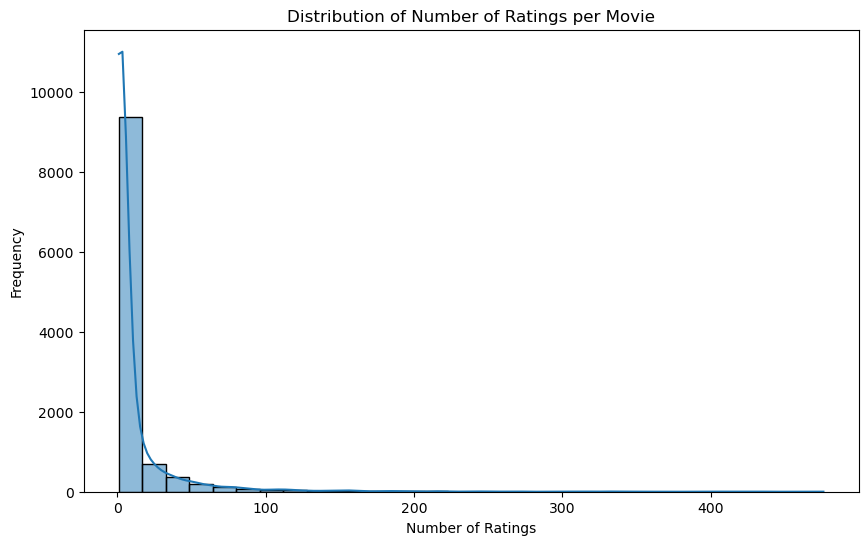

c:\Users\nafla\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


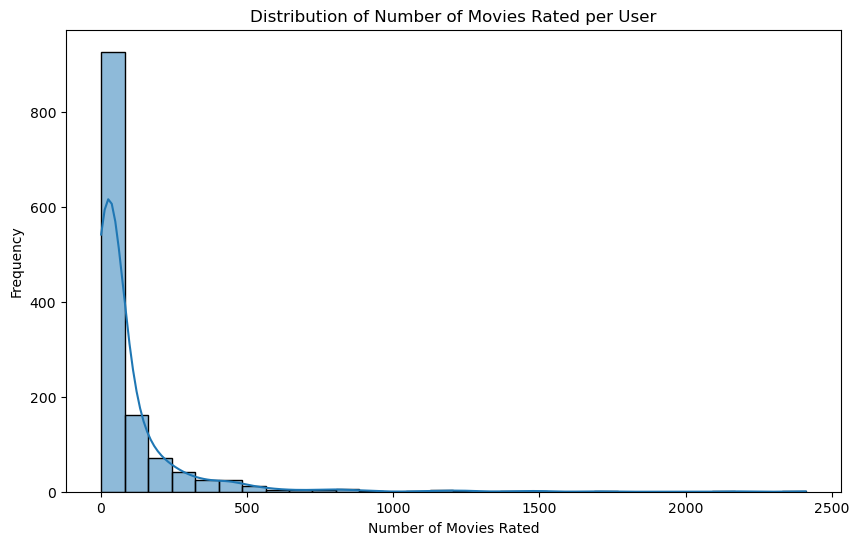

In [23]:
# Distribution of the number of ratings per movie
plt.figure(figsize=(10, 6))
sns.histplot(df.groupby('movieId')['rating'].count(), kde=True, bins=30)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Distribution of the number of movies rated per user
plt.figure(figsize=(10, 6))
sns.histplot(df.groupby('userId')['rating'].count(), kde=True, bins=30)
plt.title('Distribution of Number of Movies Rated per User')
plt.xlabel('Number of Movies Rated')
plt.ylabel('Frequency')
plt.show()


### Detecting and Handling Outliers

In [24]:
# Detecting outliers in 'rating' using IQR
def count_outliers(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data.loc[(data[feature] < lower_bound) | (data[feature] > upper_bound), feature]
    return outliers.count()

Q1 = df['rating'].quantile(0.25)
Q3 = df['rating'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# Outliers for the 'rating' column
print("Number of outliers in 'rating':", count_outliers(df, 'rating'))


Number of outliers in 'rating': 1660


In [25]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### Encoding Categorical Variables

In [26]:
df_genres = df['genres'].str.get_dummies(sep='|')
df = pd.concat([df, df_genres], axis=1)

In [27]:
df.head()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


### Creating New Features

In [28]:
# Extracting the number of genres per movie as a new feature
df['num_genres'] = df['genres'].apply(lambda x: len(x.split('|')))

In [29]:
df.head()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,num_genres
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5


In [30]:
# Correlation between 'rating' and 'num_genres'
spearman_corr, spearman_p_value = spearmanr(df['rating'], df['num_genres'])
print(f"Spearman's Correlation Coefficient: {spearman_corr}, P-value: {spearman_p_value}")

# Interpretation of Spearman's correlation
if spearman_p_value < 0.05:
    if spearman_corr > 0:
        print("There is a statistically significant positive correlation between 'rating' and 'num_genres'.")
    elif spearman_corr < 0:
        print("There is a statistically significant negative correlation between 'rating' and 'num_genres'.")
    else:
        print("There is a statistically significant but no linear correlation between 'rating' and 'num_genres'.")
else:
    print("There is no statistically significant correlation between 'rating' and 'num_genres'.")


Spearman's Correlation Coefficient: 0.0031106949888586475, P-value: 0.27075241756247964
There is no statistically significant correlation between 'rating' and 'num_genres'.


## Model Implementation

### 1. Create Train/Validation/Test Datasets

In [31]:
# splitting the data into three parts: training, validation, and testing datasets.

train_data, temp_data = train_test_split(df, test_size=0.4, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

### 2. Preprocessing Data

 This part prepares the user-item matrices, fills missing values with 0, and then converts these matrices into sparse matrix format.

In [32]:
def create_user_item_matrix(df):    #This line creates a user-item matrix using pivot_table and fills missing values with 0.
    """
    Transforms the DataFrame into a user-item matrix
    """
    pivot_table = df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    return pivot_table

train_matrix_df = create_user_item_matrix(train_data)
validation_matrix_df = create_user_item_matrix(validation_data)
test_matrix_df = create_user_item_matrix(test_data)


# Convert the DataFrame to a sparse matrix
train_matrix = csr_matrix(train_matrix_df.values)
validation_matrix = csr_matrix(validation_matrix_df.values)
test_matrix = csr_matrix(test_matrix_df.values)

### 3. Applying SVD on Training Data

In [33]:
# Performs Singular Value Decomposition on the training matrix (the CSR matrix)
U, sigma, Vt = svds(train_matrix, k=50)  # k is the number of singular values and vectors
sigma_diag_matrix = np.diag(sigma)

# Convert the matrices back to DataFrames for easier interpretation and processing
user_factors_df = pd.DataFrame(U, index=train_matrix_df.index)
movie_factors_df = pd.DataFrame(Vt.T, index=train_matrix_df.columns)  # Transpose Vt to align with movie IDs

### 4. Prediction Function

In [34]:
def predict_ratings(user_factors, sigma_diag_matrix, item_factors, user_item_matrix):
    # Prediction using dot product
    predictions = np.dot(np.dot(user_factors, sigma_diag_matrix), item_factors.T)

    # Convert predictions to a DataFrame with the same structure as the training set
    preds_df_temp = pd.DataFrame(predictions, columns=train_matrix_df.columns, index=train_matrix_df.index)

    # Reindex the predictions DataFrame to match the validation/test user-item matrix, filling missing values with 0
    preds_df = preds_df_temp.reindex(index=user_item_matrix.index, columns=user_item_matrix.columns, fill_value=0)

    return preds_df

### 5. Evaluation Function

In [35]:
# Evaluate the model's accuracy function remains unchanged
def evaluate_accuracy(predictions_df, actual_matrix_df):
    predicted_ratings = predictions_df.values.flatten()
    actual_ratings = actual_matrix_df.values.flatten()

    non_zero_indices = actual_ratings.nonzero() # finds the indices where actual ratings are non-zero. 
    actual_ratings_filtered = actual_ratings[non_zero_indices] # filters out the actual ratings corresponding to the non-zero indices found in the previous step.
    predicted_ratings_filtered = predicted_ratings[non_zero_indices]

    rmse = math.sqrt(mean_squared_error(actual_ratings_filtered, predicted_ratings_filtered))
    mae = mean_absolute_error(actual_ratings_filtered, predicted_ratings_filtered)

    return rmse, mae

In [36]:
# Evaluate on validation set
validation_preds_df = predict_ratings(U, sigma_diag_matrix, movie_factors_df, validation_matrix_df)
validation_rmse, validation_mae = evaluate_accuracy(validation_preds_df, validation_matrix_df)
print(f"Validation RMSE: {validation_rmse}, Validation MAE: {validation_mae}")


Validation RMSE: 3.375471440216466, Validation MAE: 3.185848849888439


In [37]:
# Final evaluation on the test set
test_preds_df = predict_ratings(U, sigma_diag_matrix, movie_factors_df, test_matrix_df)
test_rmse, test_mae = evaluate_accuracy(test_preds_df, test_matrix_df)
print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}")


Test RMSE: 3.372914002810467, Test MAE: 3.178107781669154


### 6. Recommendation

In [38]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    user_row_number = predictions_df.index.get_loc(userID)  # Find the user's index
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False).reset_index()
    sorted_user_predictions.columns = ['movieId', 'Predictions']

    user_data = original_ratings_df[original_ratings_df.userId == userID] # retrieves the original ratings data for the specified user

    recommendations = (movies_df[~movies_df['movieId'].isin(user_data['movieId'])]
                       .merge(sorted_user_predictions, on='movieId')
                       .sort_values('Predictions', ascending=False)
                       .iloc[:num_recommendations, :])[['title', 'Predictions']]

    return recommendations




In [39]:
user_id = 10  # Example user ID
recommendations = recommend_movies(validation_preds_df, user_id, movies, validation_data, 5)

print(f"Recommendations for User ID {user_id}:")
for index, row in recommendations.iterrows():
    print(f"{row['title']} - Rating Prediction: {row['Predictions']:.2f}")

Recommendations for User ID 10:
Dark Knight, The (2008) - Rating Prediction: 4.69
Lord of the Rings: The Fellowship of the Ring, The (2001) - Rating Prediction: 4.56
Lord of the Rings: The Return of the King, The (2003) - Rating Prediction: 4.13
Lord of the Rings: The Two Towers, The (2002) - Rating Prediction: 3.67
Matrix, The (1999) - Rating Prediction: 3.02


## SVD++

### Random Sampling

In [40]:
# Calculate the number of rows corresponding to 10% of the DataFrame
sample_size = int(len(df) * 0.01)

# Take a sample of 10% of the DataFrame at the beginning
sampled_df = df.iloc[:sample_size]

In [41]:
num_users = sampled_df['userId'].nunique()
num_items = sampled_df['movieId'].nunique()
num_factors = 50  # This is an arbitrary choice


### Creating Implicit Feedback

In [42]:
# Creating a binary implicit feedback dataset from the ratings data
sampled_df['implicit_feedback'] = 1  # Indicates interaction


C:\Users\nafla\AppData\Local\Temp\ipykernel_8528\303424862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df['implicit_feedback'] = 1  # Indicates interaction


In [43]:
# Now we need to update the implicit feedback column based on certain conditions,
# for example, we can set it to 1 if the rating is above a certain threshold.
# we consider ratings above 3 as implicit positive feedback.

sampled_df.loc[df['rating'] > 3, 'implicit_feedback'] = 1


In [44]:
# Initialize implicit user factors randomly
# Assuming 'num_users' and 'num_factors' are defined
user_factors_implicit = np.random.normal(0, .1, (num_users, num_factors))


### Splitting the Data

In [45]:
from sklearn.model_selection import train_test_split

# Split the data into training and temporary data
train_data, temp_data = train_test_split(sampled_df, test_size=0.4, random_state=42)

# Further split the temporary data into validation and testing sets
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print("Train data shape:", train_data.shape)
print("Validation data shape:", validation_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (751, 28)
Validation data shape: (251, 28)
Test data shape: (251, 28)


In [46]:
# Convert the DataFrame to a CSR matrix
train_matrix_csr = csr_matrix(train_matrix_df.values)
validation_matrix_csr = csr_matrix(validation_matrix_df.values)

### Prediction Function
The function predicts user-item ratings by combining explicit and implicit feedback through a variant of Singular Value Decomposition with Probabilistic Matrix Factorization (SVD++). It adjusts implicit user factors based on confidence factors derived from the number of items rated by each user. Predictions are computed iteratively for each user, considering both explicit and adjusted implicit feedback, and then converted into a DataFrame format for easy interpretation and further analysis.

In [48]:
def predict_ratings_svdpp_csr(user_factors_explicit, sigma_diag_matrix, item_factors, user_implicit_factors, user_item_matrix):
    # Calculate the contribution of implicit feedback for each user

    # Calculate the confidence factors based on the number of items rated by each user
    confidence_factors = np.sqrt(np.array(user_item_matrix.sum(axis=1)))

    # Adjust the implicit user factors by confidence factors
    user_factors_implicit_adjusted = user_implicit_factors * confidence_factors[:, np.newaxis]

    # Initialize an empty array to store predictions
    predictions = []

    # Reshape implicit feedback to match the number of rows in user_factors_implicit_adjusted
    implicit_feedback_repeated = np.repeat(user_factors_implicit_adjusted, user_item_matrix.shape[1], axis=1)

    # Iterate over users to compute predictions
    for i in range(user_factors_explicit.shape[0]):
        # Compute prediction for the ith user
        user_prediction = np.dot(user_factors_explicit[i, :], sigma_diag_matrix) @ item_factors.T

        # Add the contribution of implicit feedback
        implicit_feedback = implicit_feedback_repeated[i, :]

        # Compute the final prediction for the ith user
        user_prediction += implicit_feedback

        # Append the prediction for the ith user to the list
        predictions.append(user_prediction)

    # Convert predictions list to array
    predictions_array = np.array(predictions)

    # Convert predictions array to DataFrame
    preds_df = pd.DataFrame(predictions_array, columns=user_item_matrix.columns, index=user_item_matrix.index)

    return preds_df



In [ ]:
# # For example, to predict ratings on the validation set using CSR matrices:
# validation_preds_df_svdpp_csr = predict_ratings_svdpp_csr(U, sigma_diag_matrix, Vt.T, user_factors_implicit, validation_matrix_csr)


##### Because of the computational issues, we couldn't go further without using the Surprise library #####

## SVD With surprise library

In [50]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
from surprise.model_selection import GridSearchCV

In [51]:
# Defining rating scale
reader = Reader(rating_scale=(1, 5))
# Loading data to surprise data set
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

### Hyperparameter Tuning with Grid Search in Surprise Package


1. **Define Hyperparameters**: The `param_grid` dictionary defines a grid of hyperparameters that we want to search over. It includes parameters such as `n_epochs`, `lr_all`, `reg_all`, and `n_factors`.

2. **Create GridSearchCV Object**: We create a `GridSearchCV` object named `grid_search`. This object is configured with:
   - The algorithm class (`SVD` in this case) that we want to tune.
   - The parameter grid defined earlier (`param_grid`).
   - Evaluation measures (`"rmse"` and `"mae"`).
   - Number of folds for cross-validation (`cv=5` for 5-fold cross-validation).

3. **Fit GridSearchCV Object**: We fit the `GridSearchCV` object to our data (`data`). This performs an exhaustive search over the hyperparameter grid and evaluates each combination using cross-validation.

4. **Get Best Hyperparameters**: After fitting, we access the best hyperparameters found by the grid search using `best_score` and `best_params` attributes.

5. **Print Results**: Finally, we print out the best RMSE score achieved and the corresponding best hyperparameters.


In [52]:
# Define params for gread search

# n_epochs: The total number of iterations over the entire dataset during the training process.
# lr_all: The learning rate for all parameters, controlling the step size in the gradient descent optimization.
# reg_all: The regularization term for all parameters, used to penalize larger parameter values to prevent overfitting.
# n_factors: The number of latent factors to use, which represents the dimensionality of the user/item feature space.

param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6], "n_factors": [5 ,10 ,30 ,50, 100, 150]}

# Create a GridSearchCV object
grid_search = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5)

# Fit the GridSearchCV object
grid_search.fit(data)

# Get the best hyperparameters
# best RMSE score
print("Best rmse:", grid_search.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print("Best hyperparameters:", grid_search.best_params["rmse"])

Best rmse: 0.9078712679734575
Best hyperparameters: {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4, 'n_factors': 10}


In [53]:
# fit the algorithm that yields the best rmse:
algo = grid_search.best_estimator["rmse"]
algo.fit(data.build_full_trainset())

In [56]:
# Predict rating for a specific user-item pair
user_id = '1'
item_id = '1'
predicted_rating = algo.predict(user_id, item_id)
print("Predicted rating:", predicted_rating.est)

Predicted rating: 3.584323220397125


###  Defining movie recommendation function

This function `recommend_top_n_unseen_movies` recommends the top N unseen movies to a given user based on a trained model. Here's an explanation of the function:

- **Parameters**:
  - `user_id`: ID of the user for whom recommendations are to be made.
  - `model`: Trained recommender system model (e.g., SVD or SVD++).
  - `movies_df`: DataFrame containing information about movies, including MovieID and MovieTitle.
  - `n`: Number of recommendations to be made (default is 10).

**Steps**:
1. **Get Rated Movie IDs**: Extract the movie IDs rated by the user from the dataset.
2. **Get All Movie IDs**: Retrieve all unique movie IDs available in the dataset.
3. **Identify Unseen Movies**: Find the movie IDs that the user has not rated (unseen movies).
4. **Predict Ratings**: Use the trained model to predict ratings for the unseen movies.
5. **Sort Predictions**: Sort the predicted ratings in descending order to identify the top N predictions.
6. **Get Movie Titles**: Retrieve the movie titles corresponding to the top N predicted ratings.
7. **Return Recommendations**: Return the top N recommended movies along with their IDs, titles, and predicted ratings.

**Output**:
The function returns a list of tuples, where each tuple contains the MovieID, MovieTitle, and predicted rating for one of the top N recommended movies.

This function simplifies the process of recommending movies to users by automating the steps involved in predicting ratings for unseen movies and selecting the top recommendations based on these ratings.

In [59]:
def recommend_top_n_unseen_movies(user_id, model, movies_df, n=10):
    # Get all the movie IDs rated by the user
    rated_movie_ids = df[df['userId'] == user_id]['movieId'].tolist()
    
    # Get all the movie IDs in the dataset
    all_movie_ids = movies_df['movieId'].unique()
    
    # Identify the unseen movies (movies not rated by the user)
    unseen_movie_ids = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movie_ids]
    
    # Predict ratings for unseen movies
    predictions = [(movie_id, model.predict(user_id, movie_id).est) for movie_id in unseen_movie_ids]
    
    # Sort the predictions based on predicted rating in descending order
    top_n_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    
    # Get movie titles corresponding to the top N predicted ratings
    top_n_movies = [(movie_id, movies_df[movies_df['movieId'] == movie_id]['title'].iloc[0], rating) for movie_id, rating in top_n_predictions]
    
    return top_n_movies




In [62]:
# Example usage:
user_id = '10'
top_n_recommendations = recommend_top_n_unseen_movies(user_id, algo, df, n=10)
for movie_id, movie_title, predicted_rating in top_n_recommendations:
    print(f"Movie ID: {movie_id}, Movie Title: {movie_title}, Predicted Rating: {predicted_rating}")

Movie ID: 1272, Movie Title: Patton (1970), Predicted Rating: 4.146596735476239
Movie ID: 750, Movie Title: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964), Predicted Rating: 4.125893933161743
Movie ID: 318, Movie Title: Shawshank Redemption, The (1994), Predicted Rating: 4.11749940131104
Movie ID: 1227, Movie Title: Once Upon a Time in America (1984), Predicted Rating: 4.112075020275929
Movie ID: 913, Movie Title: Maltese Falcon, The (1941), Predicted Rating: 4.093381767773169
Movie ID: 1221, Movie Title: Godfather: Part II, The (1974), Predicted Rating: 4.089814866780365
Movie ID: 1213, Movie Title: Goodfellas (1990), Predicted Rating: 4.088390953021232
Movie ID: 858, Movie Title: Godfather, The (1972), Predicted Rating: 4.050690380907453
Movie ID: 109487, Movie Title: Interstellar (2014), Predicted Rating: 4.049908667362402
Movie ID: 1252, Movie Title: Chinatown (1974), Predicted Rating: 4.047183021229272


## SVD++ with Surprise

In [65]:
df['implicit_feedback'] = 1

In [66]:
# Defining data for implicit and explicit rating
implicit_data = df[['userId', 'movieId', 'implicit_feedback']]
explicit_data = df[['userId', 'movieId', 'rating']]

# Rename columns to match Surprise library's requirements
implicit_data.columns = ['userID', 'itemID', 'rating']
explicit_data.columns = ['userID', 'itemID', 'rating']

explicit_rating_scale = (1, 5)  # For explicit feedback,  ratings are between 1 and 5
implicit_rating_scale = (0, 1)  # For implicit feedback,  binary (0 or 1) feedback

# Create a custom reader
reader = Reader(rating_scale=(0, 5))


# Concatenate implicit and explicit data
data = pd.concat([implicit_data, explicit_data])

# Load the data into Surprise dataset
data = Dataset.load_from_df(data, reader)

In [68]:
from surprise import accuracy, SVDpp
from surprise.model_selection import KFold

# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = SVDpp()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 1.6403
RMSE: 1.6411
RMSE: 1.6453


### Cross Validation for Recommender System
This function implements cross-validation for evaluating the performance of a recommender system algorithm using Surprise package. The algorithm used in this function is SVD++.

#### Algorithm:
1. Initialize the SVD++ algorithm.
2. Initialize a KFold cross-validation iterator with the specified number of splits (`n_splits`).
3. Iterate over the cross-validation splits:
   - Train the SVD++ algorithm on the training set.
   - Test the algorithm on the test set.
   - Compute the Root Mean Squared Error (RMSE) for the predictions.
   - Print the RMSE for each fold.
4. After all folds are processed, print the average RMSE across all folds.

#### Output:
- For each fold, the function prints the RMSE.
- At the end, it prints the average RMSE across all folds.

In [71]:
from surprise import accuracy, SVDpp
from surprise.model_selection import KFold

# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = SVDpp()

# Dictionary to store models and their RMSE scores
models_rmse = {}

for i, (trainset, testset) in enumerate(kf.split(data), 1):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    
    # Store the model and its RMSE score
    models_rmse[f"Model_{i}"] = {"model": algo, "rmse": rmse}

# Find the model with the lowest RMSE
best_model_key = min(models_rmse, key=lambda k: models_rmse[k]["rmse"])
best_model = models_rmse[best_model_key]["model"]
best_rmse = models_rmse[best_model_key]["rmse"]

print("Best RMSE:", best_rmse)
print("Best Model:", best_model)


RMSE: 1.6401
RMSE: 1.6445
RMSE: 1.6373
Best RMSE: 1.637295257399767
Best Model: <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x000002F73CE2D990>


###  Fitting the SVD++ model

In [72]:
# fit the algorithm that yields the best rmse:
algo_pp = best_model
algo_pp.fit(data.build_full_trainset())

### Making prediction

In [74]:
# predict rating for one user as example
user_id = '10'
item_id = '1'
predicted_rating = algo_pp.predict(user_id, item_id)
print("Predicted rating:", predicted_rating.est)

Predicted rating: 2.2921616101985625


### Movie recommendation to one user

In [76]:
# Example usage:
user_id = '100'
top_n_recommendations = recommend_top_n_unseen_movies(user_id, algo_pp, df, n=10)
for movie_id, movie_title, predicted_rating in top_n_recommendations:
    print(f"Movie ID: {movie_id}, Movie Title: {movie_title}, Predicted Rating: {predicted_rating}")

Movie ID: 2920, Movie Title: Children of Paradise (Les enfants du paradis) (1945), Predicted Rating: 2.9717862084964866
Movie ID: 179135, Movie Title: Blue Planet II (2017), Predicted Rating: 2.880297406782756
Movie ID: 318, Movie Title: Shawshank Redemption, The (1994), Predicted Rating: 2.868117109047219
Movie ID: 326, Movie Title: To Live (Huozhe) (1994), Predicted Rating: 2.8525104205931995
Movie ID: 1224, Movie Title: Henry V (1989), Predicted Rating: 2.8350122640978
Movie ID: 159817, Movie Title: Planet Earth (2006), Predicted Rating: 2.826865918643177
Movie ID: 296, Movie Title: Pulp Fiction (1994), Predicted Rating: 2.8158573398838938
Movie ID: 1227, Movie Title: Once Upon a Time in America (1984), Predicted Rating: 2.815141928109008
Movie ID: 2905, Movie Title: Sanjuro (Tsubaki Sanjûrô) (1962), Predicted Rating: 2.805614891805144
Movie ID: 1272, Movie Title: Patton (1970), Predicted Rating: 2.8014893065084583
